In [26]:
import logging
import os.path
import warnings
from collections import Counter

import matplotlib
import numpy as np
import pandas as pd
import shap
import xgboost
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import where
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
    IsolationForest
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import imblearn

from explainability.explain_shap import explain_shap
from feature_extraction.text_feature_extraction import extract_bow
from preprocessing.preprocess_raw_documents import raw_corpus_preprocessing
from run_data_modeling import base_modeling
from util.constants import PATH_PLANILHA_RAW_TEXT, PATH_PLANILHA_PROC, PATH_RESULTS
import nltk

from util.setup_logging import setup_logging

import xgboost
nltk.download('punkt')
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /home/trdp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
plt.rc('axes', axisbelow=True)

# Train and test model

In [28]:
from sklearn.preprocessing import OneHotEncoder

#logging.info("Modeling using only raw text")
#logging.info("Loading and preprocessing")
dataset_df = pd.read_csv(PATH_PLANILHA_RAW_TEXT.replace("@ext", "csv"))
X = dataset_df[["Conteúdo", "Número do doc"]]
y = np.array(dataset_df["Resultado Doc"])

dict_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)
#print("Training/Testing using 5-fold cross-validation")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=4)

sent_train = list(X_train["Número do doc"])
X_train = np.array(X_train["Conteúdo"])

sent_test = list(X_test["Número do doc"])
X_test = np.array(X_test["Conteúdo"])

print("Sent to test:", sent_test[:10])

# enc = OneHotEncoder(handle_unknown='ignore')
# y_train = enc.fit_transform(y_train.reshape(-1, 1))
# y_test = enc.transform(y_test.reshape(-1, 1))


X_train_bow, bow_model = extract_bow(X_train, method="TF-IDF")
X_test_bow = extract_bow(X_test, fitted_bow=bow_model)

features_names = bow_model.get_feature_names_out()

scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)

selectFS = SelectKBest(chi2, k=100)
x_train = selectFS.fit_transform(X_train_bow, y_train)
x_test = selectFS.transform(X_test_bow)
supports = selectFS.get_support(indices=True)

features = pd.Series(features_names)[supports]
model = MLPClassifier(hidden_layer_sizes=(64, 64), early_stopping=True, shuffle=True,  verbose=False,
                      n_iter_no_change=5, solver="adam", random_state=6)
# model = xgboost.XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred, average="macro")

print("Acc %.2f F1 %.2f" % (acc,f1))
print("Test", y_test[:10])
print("pred", model.predict_proba(x_test[:10]))

#shap.summary_plot(shap_vals, feature_names=features)
#shap.force_plot(explainer.expected_value[0], shap_vals[0], x_test[:num_explanations])

Sent to test: ['PALOMA158', 'PABLOERNESTO153', 'PABLOERNESTO184', 'LUCIANO169', 'MARTINS188', 'EDI054', 'PABLOERNESTO045', 'GERSON091', 'COSTA075', 'COSTA024']
Acc 0.81 F1 0.69
Test ['Preso' 'Preso' 'Solto' 'Preso' 'Preso' 'Solto' 'Preso' 'Preso' 'Preso'
 'Solto']
pred [[0.84524907 0.15475093]
 [0.97570927 0.02429073]
 [0.91706496 0.08293504]
 [0.89437985 0.10562015]
 [0.97445686 0.02554314]
 [0.01339039 0.98660961]
 [0.97688454 0.02311546]
 [0.85236984 0.14763016]
 [0.80718956 0.19281044]
 [0.5845937  0.4154063 ]]


In [29]:
attrib_data = x_train[:10]
explainer = shap.KernelExplainer(model.predict_proba, attrib_data, feature_names=features, output_names=["Preso", "Solto"])
num_explanations = 100
shap_vals = explainer.shap_values(x_test[9:10])

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_vals[0], x_test[9:10], feature_names=features, out_names=["Preso", "Solto"])

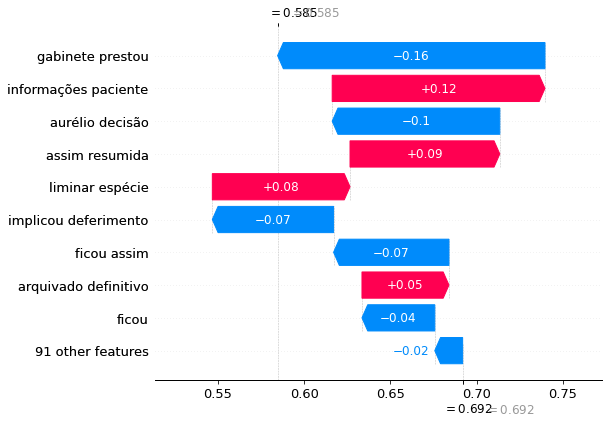

In [31]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_vals[0][0], feature_names=list(features))

Permutation explainer: 404it [00:18,  9.46it/s]                         


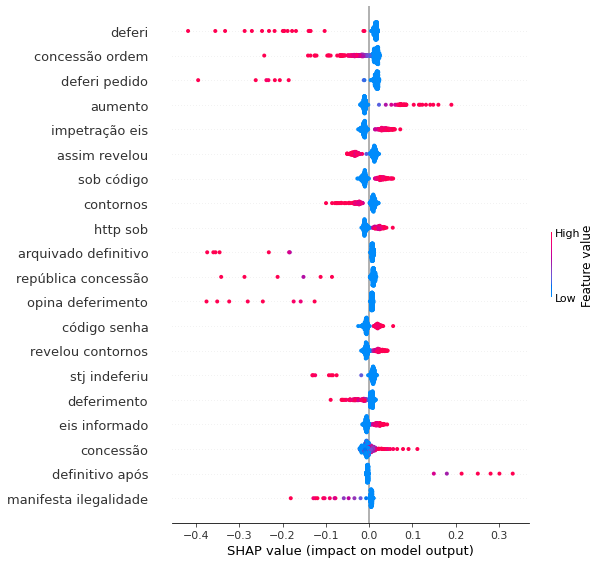

In [32]:
explainer = shap.Explainer(model.predict_proba, x_train)
shap_vals = explainer(x_test)
#shap.plots.beeswarm(shap_vals)
shap.summary_plot(np.take(shap_vals.values, 0, axis=-1), x_test, feature_names=np.array(features), show=False)
plt.savefig("explainability/results/shap_test.png")